In [1]:
import napari 
import skimage 
from skimage import data
from skimage.io import imread, imshow, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc
import os 
from os.path import isfile, join
import random

datadir = "./data/TIFF/cl80/"
savedir = os.path.join(os.path.dirname(os.path.dirname(datadir)), "Results")
if not os.path.exists(savedir):
	os.makedirs(savedir)
    
def postprocessLabelImage(rawimage, label_segmentationoutput, sizemin=5000, sizemax=50000):
    dilated = cle.dilate_labels(label_segmentationoutput, None, 2.0)
    sizefiltered = cle.exclude_labels_outside_size_range(dilated, None, sizemin, sizemax)
    merged = cle.merge_labels_with_border_intensity_within_range(image, sizefiltered, None, 2.0, 100.0)
    final = cle.relabel_sequential(merged, None, 4.0)
   
    return final 

def addNapariLabelLayer(viewer, labelimage, name=""):
    viewer.add_labels(labelimage, name=name)
    
def applyObjectSegmentator(clfile, image):
    clf = apoc.ObjectSegmenter(opencl_filename=clfile)
    outputlabels = clf.predict(image=image)
    
    return outputlabels

In [2]:
files = [f for f in os.listdir(datadir) if isfile(os.path.join(datadir, f)) and f.startswith("C4") and f.endswith(".tif")]
files

['C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap1.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap2.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap3.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap4.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap5.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap6.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap7.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap1.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap2.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap3.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap4.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap5.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap6.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap7.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap8.tif',
 'C4_cl80_

### Pick a random image to train on

C:\ProgramData\Anaconda3\envs\ilastik-napari-devbio\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


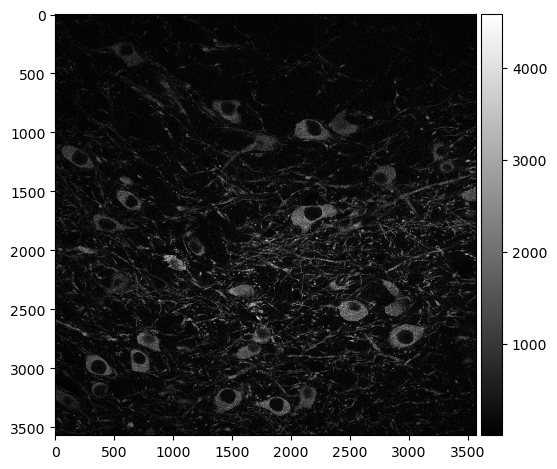

In [34]:
n = random.randint(0, len(files) - 1)
train_image = files[17]

image = imread(join(datadir, train_image))
imshow(image, cmap= 'gray')

### Open Napari to add labels manually

In [35]:
# start napari
viewer = napari.Viewer()
napari.run()

# add image
viewer.add_image(image)

<Image layer 'image' at 0x25e1c87d430>

In [14]:
# add an empty labels layer and keep it in a variable
labels = np.zeros(image.shape).astype(int)
addNapariLabelLayer(viewer, labels, name="labels")

C:\ProgramData\Anaconda3\envs\ilastik-napari-devbio\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


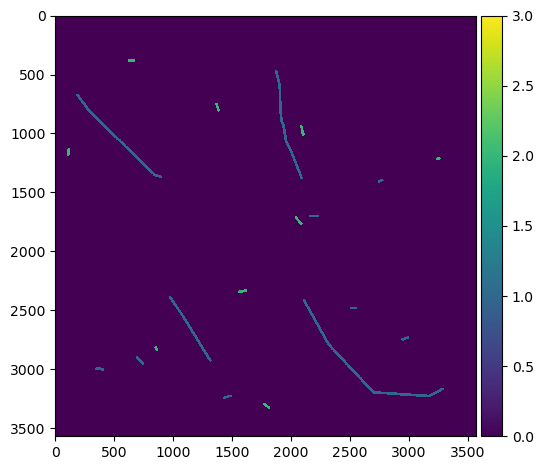

In [36]:
# labels = viewer.layers['labels'].data
# imsave(join(savedir, "labels_" + train_image), labels)

labels = imread(join(savedir, "labels_" + train_image))

imshow(labels, vmin=0, vmax=3)

### Train using image and labels

In [37]:
# define features
# features = apoc.PredefinedFeatureSet.medium_quick.value
features = "gaussian_blur=1 difference_of_gaussian=1 laplace_box_of_gaussian_blur=1 sobel_of_gaussian_blur=1  sobel_of_gaussian_blur=3  laplace_box_of_gaussian_blur=3  difference_of_gaussian=3  gaussian_blur=3  gaussian_blur=2  difference_of_gaussian=2  laplace_box_of_gaussian_blur=2  sobel_of_gaussian_blur=2 original"

# this is where the model will be saved
cl_filename = join(savedir, 'Model.cl')
apoc.erase_classifier(cl_filename)

# train 
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, labels, image)

### Do prediction on trained image

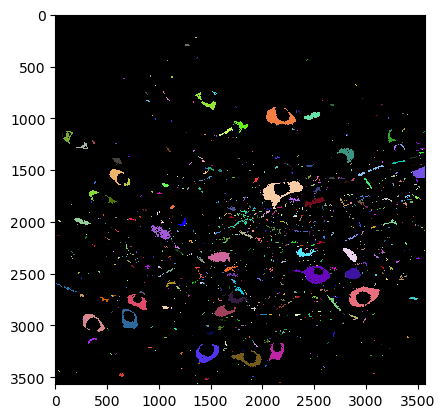

In [38]:
segmentation_result = clf.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

addNapariLabelLayer(viewer, segmentation_result, name="prediction")

C:\ProgramData\Anaconda3\envs\ilastik-napari-devbio\lib\site-packages\pyclesperanto_prototype\_tier3\_generate_touch_mean_intensity_matrix.py:30: UserWarning: generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.
Loss of information is possible when passing non-integer images.
  warnings.warn("generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.\n" +
C:\ProgramData\Anaconda3\envs\ilastik-napari-devbio\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


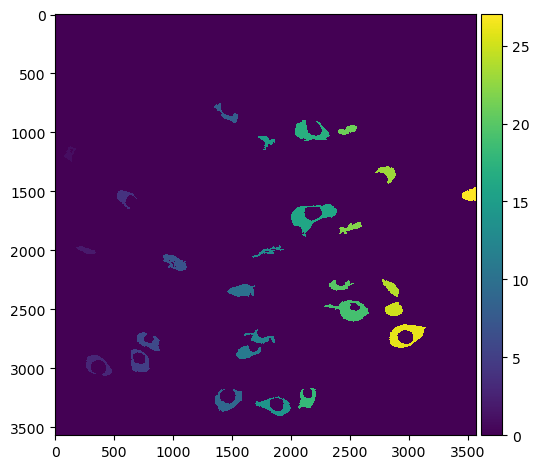

In [40]:
final_output = postprocessLabelImage(image, segmentation_result, sizemin=6000, sizemax=50000)
addNapariLabelLayer(viewer, final_output, name="final")
napari.utils.nbscreenshot(viewer)
imshow(final_output)

In [30]:
output = viewer.layers['final'].data
imsave(join(savedir, "output_" + train_image), output)

C:\Users\nadar.gayathri\AppData\Local\Temp\ipykernel_26404\1422234521.py:2: UserWarning: ./data/TIFF\Results\output_C4_cl80_s1_lame1_line1_slice4_th_psyn_lamp1_lc3_x40_snap3.tif is a low contrast image
  imsave(join(savedir, "output_" + train_image), output)


In [ ]:
result_dilated = cle.dilate_labels(segmentation_result, None, 2.0)
viewer.add_labels(result_dilated, name='Result_dilated')
napari.utils.nbscreenshot(viewer)

In [ ]:
result_sizefiltered = cle.exclude_labels_outside_size_range(result_dilated, None, 5000.0, 50000.0)
viewer.add_labels(result_sizefiltered, name='Result_sizeFilter')
napari.utils.nbscreenshot(viewer)

In [ ]:
result_merged = cle.merge_labels_with_border_intensity_within_range(image, result_sizefiltered, None, 2.0, 100.0)
viewer.add_labels(result_merged, name='Result_mergeLabels')
napari.utils.nbscreenshot(viewer)

In [ ]:
result_final = cle.relabel_sequential(result_merged, None, 4.0)
viewer.add_labels(result_final, name='Result_final')
napari.utils.nbscreenshot(viewer)

C:\ProgramData\Anaconda3\envs\ilastik-napari-devbio\lib\site-packages\pyclesperanto_prototype\_tier3\_generate_touch_mean_intensity_matrix.py:30: UserWarning: generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.
Loss of information is possible when passing non-integer images.
  warnings.warn("generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.\n" +


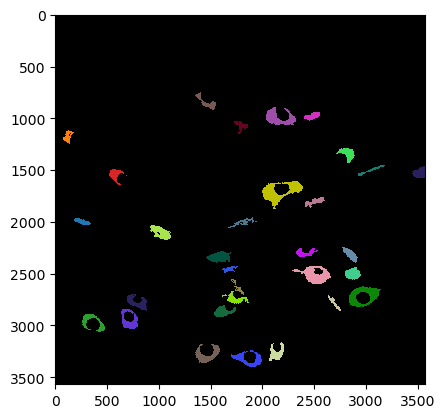

In [32]:
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename)

image_test = imread(join(datadir, files[5]))
output_test = clf.predict(image=image)

output_test_final = postprocessLabelImage(image_test, output_test)

cle.imshow(output_test_final, labels=True)

In [33]:
imsave(join(savedir, "output_" + files[5]), output_test_final)

C:\Users\nadar.gayathri\AppData\Local\Temp\ipykernel_26404\2111654546.py:1: UserWarning: ./data/TIFF\Results\output_C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap6.tif is a low contrast image
  imsave(join(savedir, "output_" + files[5]), output_test_final)
